In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # pipeline compatível com SMOTE

RANDOM_STATE = 42
sns.set(style="whitegrid", palette="Blues_d")

In [2]:
df = pd.read_csv("creditcard.csv")
TARGET = "Class"

print("Shape:", df.shape)
print("Distribuição da variável alvo:")
print(df[TARGET].value_counts(normalize=True))

Shape: (284807, 31)
Distribuição da variável alvo:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


### Banco de Dados:

---



In [14]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

Numéricas: 30 | Categóricas: 0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "| Test:", X_test.shape)

Train: (213605, 30) | Test: (71202, 30)


### Pré-processamento + SMOTE + Modelo (Pipeline Completo)

---



In [5]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

### Pipeline completo com SMOTE + Regressão Logística balanceada

---



In [6]:
pipe = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Time', 'V1', 'V2', 'V3',
                                                   'V4', 'V5', 'V6', 'V7', 'V8',
                                                   'V9', 'V10', 'V11', 'V12',
                                                   'V13', 'V14', 'V15', 'V16',
                                                   'V17', 'V18', 'V19', 'V20',
                                                   'V21', 'V22', 'V23', 'V24',
                                                   'V25', 'V26', 'V27', 'V28',
                                                   'Amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

O Balanceamento de classes SMOTE aumenta artificialmente a classe de fraude classe 1 gerando exemplos sintéticos , corrige o desbalanceamento e melhora a capacidade do modelo de detectar fraudes reais.

O Modelo LogisticRegression com class_weight='balanced' para reforçar a importância da classe 1 e produz probabilidades que permitem calibrar o limiar cutoff e maximizar o Recall.

O objetivo é maximizar a detecção de fraudes classe 1, mesmo com poucos casos positivos.


=== Classification Report (Cutoff 0.5) ===
              precision    recall  f1-score   support

           0     0.9998    0.9756    0.9875     71079
           1     0.0591    0.8862    0.1108       123

    accuracy                         0.9754     71202
   macro avg     0.5294    0.9309    0.5492     71202
weighted avg     0.9982    0.9754    0.9860     71202



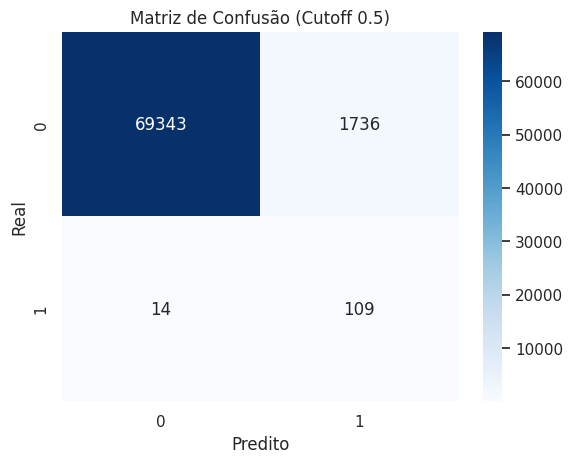

In [7]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("\n=== Classification Report (Cutoff 0.5) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão (Cutoff 0.5)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

Verdadeiros Negativos : 69.343 → o modelo acertou a maioria das vezes que o caso era 0.

Falsos Positivos : 1.736 → o modelo classificou incorretamente 1.736 casos como 1 quando eram 0.

Falsos Negativos : 14 → o modelo deixou passar 14 casos que eram 1 (falhou em detectar).

Verdadeiros Positivos: 109 → o modelo detectou corretamente 109 dos 123 casos positivos.

### Ajuste do Limiar Cutoff para Melhorar Classe 1

---



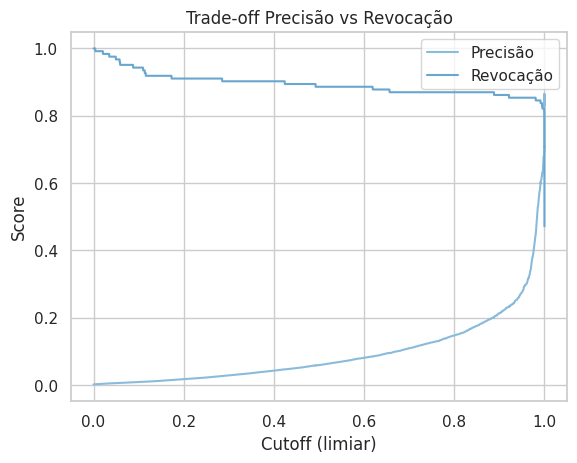

In [8]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, precisions[:-1], label='Precisão')
plt.plot(thresholds, recalls[:-1], label='Revocação')
plt.xlabel('Cutoff (limiar)')
plt.ylabel('Score')
plt.title('Trade-off Precisão vs Revocação')
plt.legend()
plt.show()

### Ajuste do Limiar

---



In [9]:
# limite que maximiza o F1 da classe 1
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] #ou trocar pelo limiar desejado
print(f"Melhor cutoff pelo F1 da classe 1: {best_threshold:.3f}")

Melhor cutoff pelo F1 da classe 1: 1.000


### Modelo com o melhor Limiar

---



In [10]:
y_pred_adj = (y_proba >= best_threshold).astype(int)
print("\n=== Classification Report (Cutoff ajustado) ===")
print(classification_report(y_test, y_pred_adj, digits=4))


=== Classification Report (Cutoff ajustado) ===
              precision    recall  f1-score   support

           0     0.9996    0.9997    0.9997     71079
           1     0.8435    0.7886    0.8151       123

    accuracy                         0.9994     71202
   macro avg     0.9216    0.8942    0.9074     71202
weighted avg     0.9994    0.9994    0.9994     71202



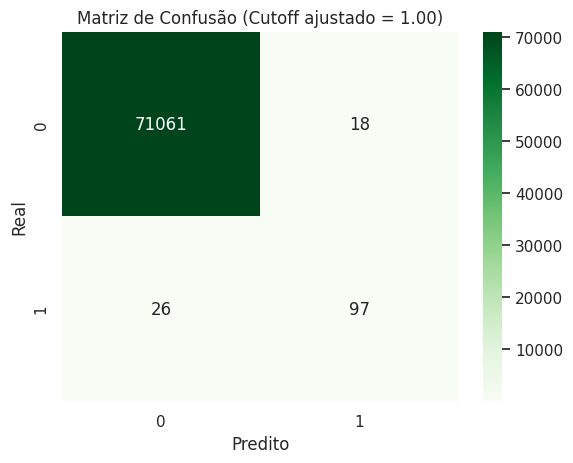

In [11]:
cm_adj = confusion_matrix(y_test, y_pred_adj)
sns.heatmap(cm_adj, annot=True, fmt='d', cmap='Greens')
plt.title(f"Matriz de Confusão (Cutoff ajustado = {best_threshold:.2f})")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

Modelo  mais conservador
Reduziu drasticamente os falsos alarmes falsos positivos, mas passou a deixar escapar algumas fraudes.
Treinar com liniar entre  0.1 a 0.3 para o modelo não ficar tão conservador.

---




In [12]:
roc_auc = roc_auc_score(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred_adj)

print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Average Precision (AUC-PR): {avg_precision:.4f}")
print(f"F1-Score (classe 1, cutoff ajustado): {f1:.4f}")

AUC-ROC: 0.9725
Average Precision (AUC-PR): 0.7107
F1-Score (classe 1, cutoff ajustado): 0.8151


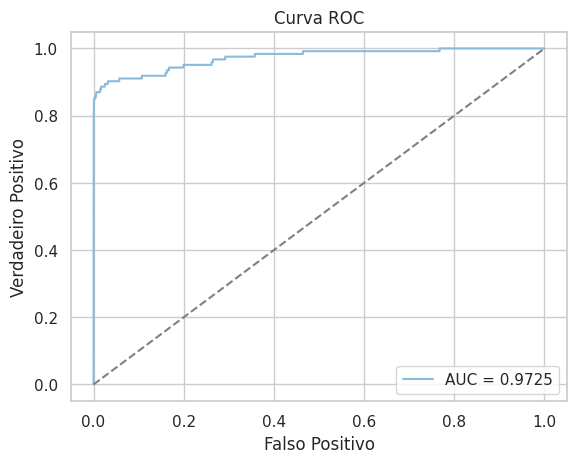

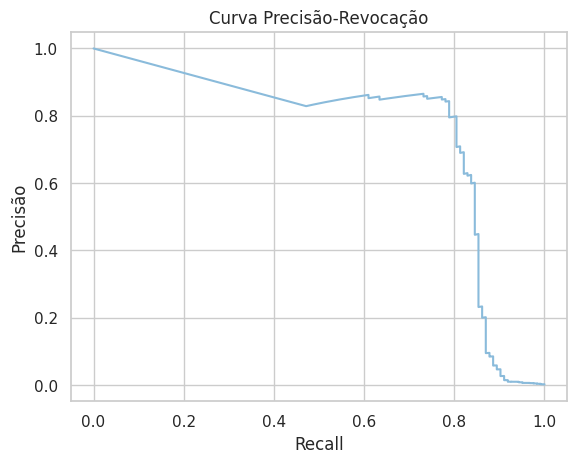

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title("Curva ROC")
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.legend()
plt.show()

plt.plot(recalls, precisions)
plt.title("Curva Precisão-Revocação")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.show()




Eixo X  representa a taxa de falsos positivos — ou seja, quantas vezes o modelo classificou uma transação legítima como fraude.

Eixo Y  representa a taxa de verdadeiros positivos — quantas fraudes o modelo realmente detectou corretamente.

Nesse caso  o modelo consegue detectar a maioria das fraudes alta sensibilidade com poucos falsos alarmes alta especificidade o modelo tem forte poder discriminativo.

